In [3]:
import pandas as pd #provides data structures for efficiently storing and analyzing data
import matplotlib.pyplot as plt #visualization library/  provides a simple interface for creating various types of plots and charts.
import seaborn as sns # It provides a high-level interface for creating aesthetically pleasing and informative statistical graphics.
from sklearn.feature_extraction.text import CountVectorizer #It is used to convert a collection of text documents into a matrix of token counts.
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # a set of English stop words provided by Scikit-learn
from sklearn.naive_bayes import MultinomialNB #a classification algorithm provided by Scikit-learn, used for text classification tasks
from sklearn.metrics import accuracy_score #calculate the accuracy of a classification model's predictions.
from sklearn.linear_model import LogisticRegression #a classification algorithm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np

Text Preprocessing

In [4]:
def clean_and_convert_text(raw_text):
    import unicodedata
    import nltk
    import string
    import contractions

    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)

    def convert_utf(text):
        text = text.replace('\u2018', "'").replace('\u2019', "'").replace('\u201C', "`").replace('\u201D', "`").replace('\u2013', '-').replace('\u2014', '-')
        text = unicodedata.normalize('NFKD', text)
        text = text.encode('ascii', 'ignore')
        return text.decode('ascii')

    UTF_text = convert_utf(raw_text)
    normalised_text = UTF_text.lower()
    words = nltk.word_tokenize(normalised_text)

    #Remove punctuations and expand contractions
    words = [contractions.fix(word) for word in words if word not in string.punctuation]

    #Remove numbers and specific symbols
    words = [word for word in words if not word.isdigit() and word not in ['---', '...', '***']]

    #Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]

    return words

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd

train_path = "/content/drive/My Drive/Colab Notebooks/Train.csv"
test_path  = "/content/drive/My Drive/Colab Notebooks/Test.csv"

# Load datasets
train_df = pd.read_csv(train_path, encoding="utf-8")
test_df  = pd.read_csv(test_path, encoding="utf-8")

df = pd.read_csv(train_path)
df = pd.read_csv(test_path)


In [9]:
# Check shapes
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Preview
print(train_df.head())
print(test_df.head())

Train shape: (39650, 3)
Test shape: (15581, 2)
      Tweet_ID                                              tweet  \
0  ID_0022DWKP  Had a dream i got raped last night. By a guy i...   
1  ID_00395QYM  he thought the word raped means sex and told m...   
2  ID_003EOSSF  She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...   
3  ID_004BBHOD  I was sexually abused for 3 years at age 4 to ...   
4  ID_004F7516  Chessy Prout can do better by telling the trut...   

              type  
0  sexual_violence  
1  sexual_violence  
2  sexual_violence  
3  sexual_violence  
4  sexual_violence  
      Tweet_ID                                              tweet
0  ID_0095QL4S  because he was my boyfriend, and if I said no,...
1  ID_00DREW5O  lol no, I'm telling you it's not legal. It's l...
2  ID_00E9F5X9  Somalia's semi-autonomous Puntland region has ...
3  ID_00G9OSKZ  University of Cape Coast students being robbed...
4  ID_00HU96U6  "Somebody came up behind him and stabbed him i...


In [10]:
import re

def clean_and_convert_text(text):
    text = str(text).lower()                       # lowercase
    text = re.sub(r'http\S+', '', text)            # remove urls
    text = re.sub(r'@\w+', '', text)               # remove mentions
    text = re.sub(r'#', '', text)                  # remove hashtag symbol
    text = re.sub(r'[^a-z\s]', '', text)           # keep only letters and spaces
    tokens = text.split()                          # tokenize by spaces
    return tokens                                  # return list of tokens


In [11]:
tweets = train_df['tweet']  #text data
categories = train_df['type']  #labels

#Preprocess the tweets
preprocessed_tweets = tweets.apply(clean_and_convert_text).str.join(' ')

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=3, max_features=3000)#at least 3 documents of the corpus to be included in the resulting vocabulary. & limit the number of feature [1]
X = vectorizer.fit_transform(preprocessed_tweets).toarray()#[1]

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(categories)#[2]

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [15]:
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.5), #due the imblance nature of data, Dropout helps orevent overfittinvg
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')  #Adjust the output layer to match the types [3 line 69-97]
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])#[line 79] #Adam: adjusts the weights of the network to minimize the loss function.

## Neural network: [line 65]
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=120, epochs=10, shuffle=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.8793 - loss: 0.4292 - val_accuracy: 0.9953 - val_loss: 0.0137
Epoch 2/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9991 - loss: 0.0049 - val_accuracy: 0.9961 - val_loss: 0.0132
Epoch 3/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 0.9961 - val_loss: 0.0152
Epoch 4/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9964 - val_loss: 0.0146
Epoch 5/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9998 - loss: 8.2875e-04 - val_accuracy: 0.9967 - val_loss: 0.0149
Epoch 6/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9999 - loss: 5.0615e-04 - val_accuracy: 0.9970 - val_loss: 0.0155
Epoch 7/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9999 - loss: 6.7733e-04 - val_accuracy: 0.9968 - val_loss: 0.0164
Epoch 8/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9999 - loss

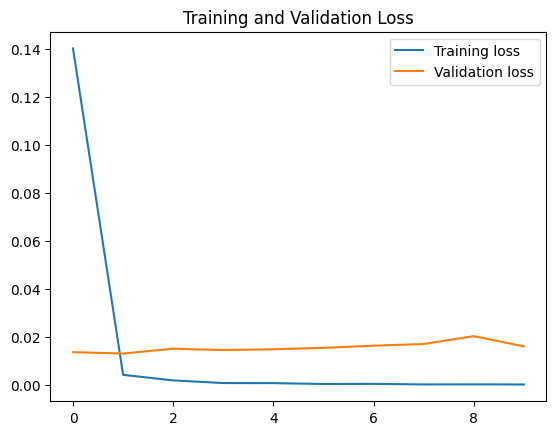

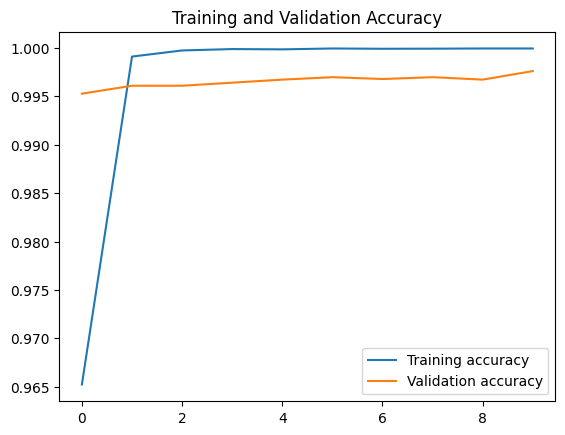

In [16]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Graph1 (training and validation loss) shows the model is generlaising well, the training loss starts high then maintian at a steady low level and validation loss matain at a low level overall, which means the model is able learn from the data.

Graph 2(training and valisation accuracy): the training accuracy rises sharply and maintain at a high performance, same with valisation accuracy, therefore also present the model is learning well from the data.

In [17]:
evaluation = model.evaluate(X_test, y_test, verbose=1)
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

print(classification_report(y_test, predicted_classes))

496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9974 - loss: 0.0165
496/496 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        80
           1       1.00      0.99      1.00      2391
           2       0.99      1.00      0.99        92
           3       0.97      0.98      0.98       253
           4       1.00      1.00      1.00     13044

    accuracy                           1.00     15860
   macro avg       0.99      0.99      0.99     15860
weighted avg       1.00      1.00      1.00     15860



In [18]:
from tensorflow.keras.models import save_model

# save model
save_model(model, "model.h5")

In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import load_model

# Use the existing test_df variable instead of loading the file again
test_data = test_df

#Preprocess the test tweets
preprocessed_test_tweets = test_data['tweet'].apply(clean_and_convert_text).str.join(' ')

#Vectorize the preprocessed test tweets
# Reuse the vectorizer fitted on the training data
X_test_transformed = vectorizer.transform(preprocessed_test_tweets).toarray()

#Load the  model
model = load_model("model.h5")

#Use the model to predict labels for the test data
predictions = model.predict(X_test_transformed)
predicted_labels = np.argmax(predictions, axis=1)

test_data['predicted_label'] = label_encoder.inverse_transform(predicted_labels)

test_data.to_csv("Predicted_label_oversampling_DNN.csv", index=False)

# Display the first few rows of the test data with predicted labels
print("Test Data with Predicted Labels:")
print(test_data.head())

# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, predicted_classes))

487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Test Data with Predicted Labels:
      Tweet_ID                                              tweet  \
0  ID_0095QL4S  because he was my boyfriend, and if I said no,...   
1  ID_00DREW5O  lol no, I'm telling you it's not legal. It's l...   
2  ID_00E9F5X9  Somalia's semi-autonomous Puntland region has ...   
3  ID_00G9OSKZ  University of Cape Coast students being robbed...   
4  ID_00HU96U6  "Somebody came up behind him and stabbed him i...   

                predicted_label  
0               sexual_violence  
1  Harmful_Traditional_practice  
2  Harmful_Traditional_practice  
3               sexual_violence  
4               sexual_violence  

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        80
           1       1.00      0.99      1.00      2391
           2       0.99      1.00      0.99        92
           3       0.97      0.98      0.98       253
           4

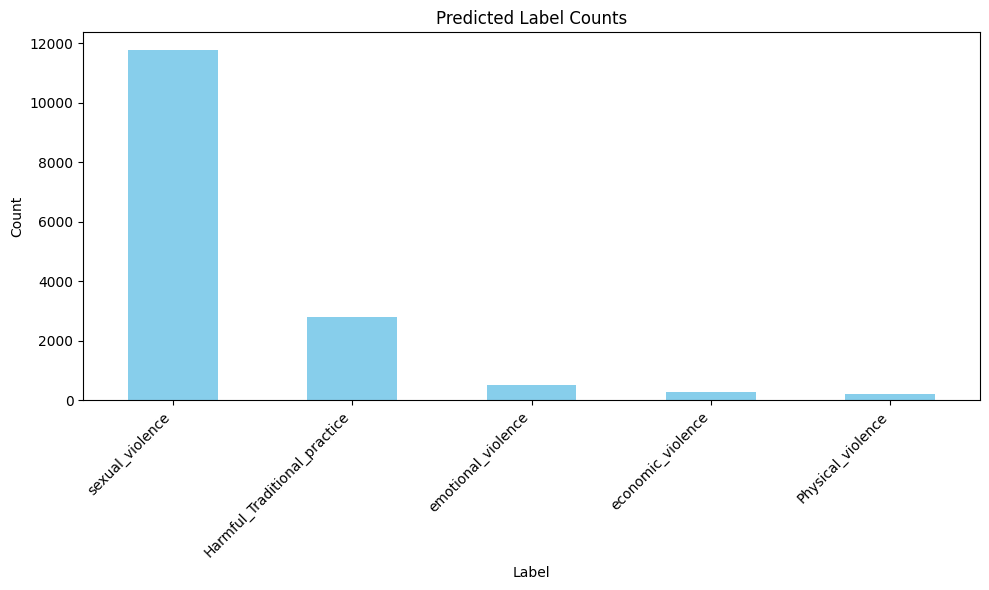

In [21]:
import matplotlib.pyplot as plt

#Count occurrences
predicted_label_counts = test_data['predicted_label'].value_counts()

#Plotting the bar chart
plt.figure(figsize=(10, 6))
predicted_label_counts.plot(kind='bar', color='skyblue')
plt.title('Predicted Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()